# Advanced Lane Lines

In [1]:
import numpy as np
import os
import cv2
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual, SelectionSlider, IntSlider, FloatSlider
from tqdm import tqdm
from collections import deque
%matplotlib inline

## Camera calibration

In [2]:
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(f'Camera matrix:\n{mtx} \nDistortion coefficients: {dist}')

Camera matrix:
[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
Distortion coefficients: [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


## Compute perspective transformations

In [3]:
def get_roi(img_shape, roi_top_ratio, roi_top_width_ratio, roi_bottom_width_ratio=1):
    """
    Region of interest is defined as an isosceles trapezoid, with the base being the entire botton of the image.
    We then only define its height (roi_top) and the width of the top edge (roi_top_width)
    """
    height, width = img_shape[0], img_shape[1]

    roi_top = roi_top_ratio * height
    roi_top_width = roi_top_width_ratio * width
    roi_bottom_width = roi_bottom_width_ratio * width
    roi = np.array([
        [(width - roi_bottom_width) // 2, height],
        [(width - roi_top_width) // 2, roi_top],
        [(width + roi_top_width) // 2, roi_top],
        [(width + roi_bottom_width) // 2, height]], dtype=np.int32)
    return roi


In [4]:
test_image = cv2.imread('test_images/straight_lines1.jpg')
undistorted = cv2.undistort(test_image, mtx, dist, None, mtx)

def compute_perspective_transform(source, destination):
    transform = cv2.getPerspectiveTransform(source, destination)
    inverse_transform = cv2.getPerspectiveTransform(destination, source)
    return transform, inverse_transform

def get_shapes_from_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height):
    h, w = test_image.shape[0], test_image.shape[1]
    source = get_roi((h, w), roi_top, roi_top_width, roi_bottom_width).astype("float32")
    target_width = t_width * w
    target_height = t_height * h
    destination = np.array([
        [(w-target_width)//2, (h+target_height)//2], 
        [(w-target_width)//2, (h-target_height)//2], 
        [(w+target_width)//2, (h-target_height)//2], 
        [(w+target_width)//2, (h+target_height)//2]], dtype = "float32")
    return source, destination

def preview_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height):
    
    src, dst = get_shapes_from_params(roi_top, roi_top_width, roi_bottom_width, t_width, t_height)
    M, Minv = compute_perspective_transform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax1.add_patch(patches.Polygon(src,linewidth=1,edgecolor='r',facecolor='none'))
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.add_patch(patches.Polygon(dst,linewidth=1,edgecolor='r',facecolor='none'))

w = interactive(preview_params, {'manual': False}, 
                roi_top=FloatSlider(0.64, min=0.0, max=1.0, step=0.01), 
                roi_top_width=FloatSlider(0.09, min=0.0, max=1.0, step=0.01),
                roi_bottom_width=FloatSlider(0.69, min=0.0, max=1.0, step=0.01),
                t_width=FloatSlider(0.59, min=0.0, max=1.0, step=0.01),
                t_height=FloatSlider(0.96, min=0.0, max=1.0, step=0.01))
display(w)

interactive(children=(FloatSlider(value=0.64, description='roi_top', max=1.0, step=0.01), FloatSlider(value=0.…

In [5]:
src, dst = get_shapes_from_params(
    w.kwargs['roi_top'], w.kwargs['roi_top_width'], w.kwargs['roi_bottom_width'], 
    w.kwargs['t_width'], w.kwargs['t_height'])

print(f'src:\n{src}\ndst:\n{dst}')
M, Minv = compute_perspective_transform(src, dst)
print(f"M transform:\n{M}\nMinv transform:\n{Minv}")

src:
[[ 198.  720.]
 [ 582.  460.]
 [ 697.  460.]
 [1081.  720.]]
dst:
[[ 262.  705.]
 [ 262.   14.]
 [1017.   14.]
 [1017.  705.]]
M transform:
[[-6.07025790e-01 -1.51875812e+00  1.02769299e+03]
 [-4.20672850e-16 -1.92004762e+00  8.81927454e+02]
 [-5.41442279e-19 -2.37491496e-03  1.00000000e+00]]
Minv transform:
[[ 1.49680244e-01 -7.91000234e-01  5.43779484e+02]
 [ 1.07419809e-16 -5.20820415e-01  4.59325823e+02]
 [ 2.31477305e-19 -1.23690420e-03  1.00000000e+00]]


## Color filtering

In [6]:
def color_filter(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Isolate the yellow color values
    yellow_mask = cv2.inRange(hsv, (20, 100, 100), (25, 255, 255))

    # Isolate the white color values
    white_mask = cv2.inRange(hsv, (0, 0, 215), (180, 32, 255))
    
    binary = sxbinary | white_mask | yellow_mask
    
    return binary

In [7]:
test_images = [
    cv2.imread('test_images/straight_lines1.jpg'), 
    cv2.imread('test_images/test1.jpg'),
    cv2.imread('test_images/test2.jpg'),
    cv2.imread('test_images/test3.jpg'),
    cv2.imread('test_images/test4.jpg'),
    cv2.imread('test_images/test5.jpg'),
    cv2.imread('test_images/test6.jpg'),
    cv2.imread('error_images/latest.jpg'),
]

def preview_params(s_thresh_min, s_thresh_max, sx_thresh_min, sx_thresh_max):
    fig, axes = plt.subplots(math.ceil(len(test_images)/2), 2, figsize=(20,20))
    for test_image, ax in zip(test_images, [b for a in axes for b in a]):
        ax.imshow(color_filter(test_image, (s_thresh_min, s_thresh_max), (sx_thresh_min, sx_thresh_max)), cmap='gray')
#out = process_image(test_image, mtx, dist, M, Minv, s_thresh, sx_thresh)
w = interactive(preview_params, {'manual': False}, 
                s_thresh_min=IntSlider(170, 0 ,255), s_thresh_max=IntSlider(250, 0, 255), 
                sx_thresh_min=IntSlider(60, 0, 255), sx_thresh_max=IntSlider(150, 0, 255))
display(w)

interactive(children=(IntSlider(value=170, description='s_thresh_min', max=255), IntSlider(value=250, descript…

In [8]:
s_thresh = (w.kwargs['s_thresh_min'], w.kwargs['s_thresh_max'])
sx_thresh = (w.kwargs['sx_thresh_min'], w.kwargs['sx_thresh_max'])
print(s_thresh, sx_thresh)

(170, 250) (60, 150)


## Line finding

In [9]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2) if len(leftx) > 0 else  []
    right_fit = np.polyfit(righty, rightx, 2) if len(rightx) > 0 else []
        
    return left_fit, right_fit

def draw_lane( left, right, img_shape):
    mask = np.zeros(img_shape, dtype=np.uint8)
    
    if len(left) > 2 and len(right) > 2: 
        y = np.linspace(0, img_shape[0]-1, img_shape[0])
    
        x_left = left[0] * y**2 + left[1] * y + left[2]
        x_right = right[0]* y**2 + right[1]* y + right[2]

        points = np.array([list(zip(x_left, y))+list(zip(x_right, y))[::-1]], dtype="int")
        cv2.fillPoly(mask, points, (0, 255, 0))
        
    return mask

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30.0/700 # meters per pixel in y dimension
xm_per_pix = 3.7/780 # meters per pixel in x dimension

def scale_poly(p, scale_x, scale_y):
    ## y = ax^2 + bx + c
    a = scale_y / (scale_x ** 2) * p[0]
    b = (scale_y/scale_x) * p[1]
    c = scale_y * p[2]
    #print(p, [a,b,c])
    return [a,b,c]
    
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    left_curverad, right_curverad = 0, 0
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    if len(left_fit) > 2:
        left_fit_scaled = scale_poly(left_fit, ym_per_pix, xm_per_pix)
        left_curverad = ((1 + (2*left_fit_scaled[0]*y_eval*ym_per_pix + left_fit_scaled[1])**2)**1.5) / np.absolute(2*left_fit_scaled[0])
    
    if len(right_fit) > 2:
        right_fit_scaled = scale_poly(right_fit, ym_per_pix, xm_per_pix)
        right_curverad = ((1 + (2*right_fit_scaled[0]*y_eval*ym_per_pix + right_fit_scaled[1])**2)**1.5) / np.absolute(2*right_fit_scaled[0])
        
    return left_curverad, right_curverad

def dist_to_lane_center(left_fit, right_fit, img_shape):
    x_left = left_fit[0] * img_shape[0]**2 + left_fit[1] * img_shape[0] + left_fit[2]
    x_right = right_fit[0] * img_shape[0]**2 + right_fit[1] * img_shape[0] + right_fit[2]
    
    lane_center = x_left + (x_right - x_left)//2
    img_center = img_shape[1] // 2
    dx = (lane_center - img_center) * xm_per_pix

    return dx


def print_stats(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_curve, right_curve = measure_curvature_real(ploty, left_fit, right_fit)
    dist_to_center = dist_to_lane_center(left_fit, right_fit, img.shape)
    out = cv2.putText(img, f'Radius of curvature {(left_curve + right_curve)//2}(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    out = cv2.putText(out, f'Vehicle is {dist_to_center:.2f}(m) left of lane center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA) 
    return out
    

Find lines in a single image

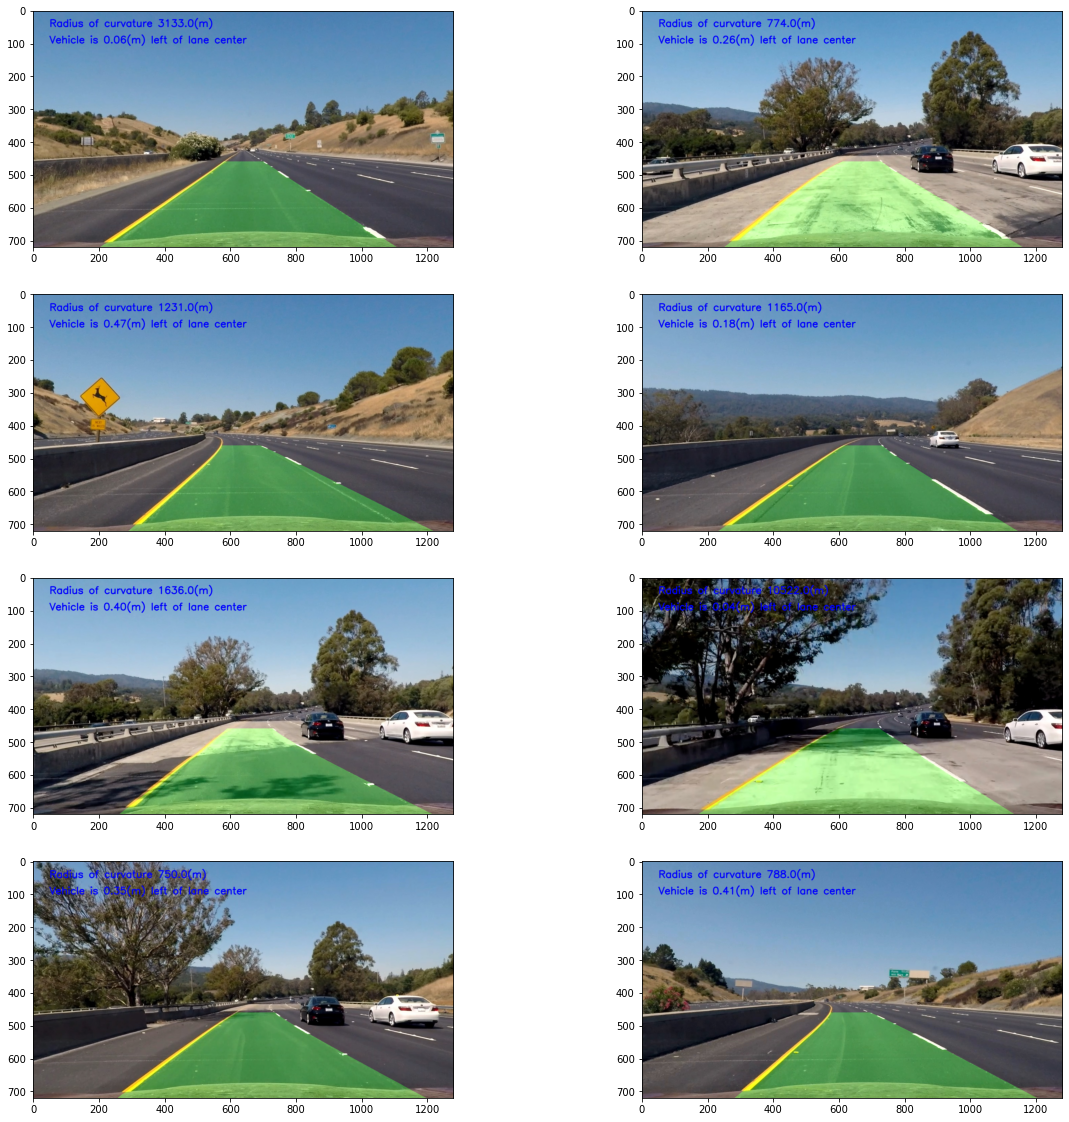

In [11]:
def process_image(image, camera_matrix, distortion_coeff, warp, warp_inv, s_thresh, sx_thresh):
    orig = np.copy(image)
    # undistort image using camera parameters computed during calibration
    undistorted = cv2.undistort(orig, mtx, dist, None, mtx)
    # binarize image
    filtered = color_filter(undistorted, s_thresh, sx_thresh)
    # change perspective
    warpped = cv2.warpPerspective(filtered, warp, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # find lines in warped binary image
    left_fit, right_fit = fit_polynomial(warpped)
    # Plots the left and right polynomials on the lane lines
    line_img = draw_lane(left_fit, right_fit, undistorted.shape)
    # change perspective back
    line_img = cv2.warpPerspective(line_img, warp_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # merge images
    out_img = weighted_img(undistorted, line_img, α=0.3)
    out_img = print_stats(out_img, left_fit, right_fit)
    return out_img

fig, axes = plt.subplots(math.ceil(len(test_images)/2), 2, figsize=(20,20))
for test_image, ax in zip(test_images, [b for a in axes for b in a]):
    out = process_image(test_image, mtx, dist, M, Minv, s_thresh, sx_thresh)
    ax.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [12]:
source_dir = 'test_images'
target_dir = 'output_images'

for img_file in os.listdir(source_dir):
    img = cv2.imread(os.path.join(source_dir, img_file))
    processed_img = process_image(img, mtx, dist, M, Minv, s_thresh, sx_thresh)
    cv2.imwrite(os.path.join(target_dir, img_file), processed_img)

Process an entire video by tracking the lines through consecutive images

In [13]:
out_video = 'output_videos'
if not os.path.exists(out_video):
    os.mkdir(out_video)

error_dir = 'error_images'
if not os.path.exists(error_dir):
    os.mkdir(error_dir)

In [14]:
N = 5  # length of history

class Line():
    def __init__(self):
        # polynomial coefficients for the most recent fit
        self.current_fit = None
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # last polynomial coefficients
        self.last_fits = deque(maxlen=N)
        self.last_curvatures = deque(maxlen=N)
        
    def update(self, poly_fit, curvature):
        self.current_fit = poly_fit
        self.radius_of_curvature = curvature
        # if valid, add to history
        if self.is_valid():
            self.last_fits.append(self.current_fit)
            self.last_curvatures.append(self.radius_of_curvature)
    
    def is_valid(self):
        is_valid_fit = len(self.current_fit) == 3
        avg_curvature = np.average(self.last_curvatures)
        is_valid_curvature = self.radius_of_curvature > 100 and (
                abs(self.radius_of_curvature - avg_curvature) < 3000) if len(self.last_curvatures) == N else True
        
        return is_valid_fit and is_valid_curvature
        
    def get_best_fit(self):
        #return np.average(self.last_fits, weights=range(1, len(self.last_fits)+1), axis=0)
        return np.average(self.last_fits, axis=0).tolist()

def eval(p, x):
    return p[0] * x**2 + p[1] * x + p[2] if len(p) == 3 else 0
 
class Lane():
    
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
    
    def update(self, left_fit, right_fit, img_shape):
        ploty = np.linspace(img.shape[0]//2, img.shape[0]-1, img.shape[0])
        
        bottom = eval(right_fit, max(ploty)) - eval(left_fit, max(ploty))
        top = eval(right_fit, min(ploty)) - eval(left_fit, min(ploty))
        
        # define a range of valid lane width in pixels relative to the image width
        min_w, max_w = 1/5 * img_shape[1], 4/5 * img_shape[1]
        
        # top, bottom of lane should be valid and close to one another
        if (min_w < top < max_w) and (min_w < bottom < max_w) and (abs(top-bottom) < 300):
            left_curve, right_curve = measure_curvature_real(ploty, left_fit, right_fit)
            self.left_line.update(left_fit, left_curve)
            self.right_line.update(right_fit, right_curve)
        else:
            print(min_w, max_w, top, bottom, abs(top-bottom))
    
    def get_best_fit(self):
        return self.left_line.get_best_fit(), self.right_line.get_best_fit()
        

In [15]:
def process_video(source, camera_matrix, distortion_coeff, warp, warp_inv, s_thresh, sx_thresh):
    source_clip = VideoFileClip(source)
    output_path =  f'output_videos/{source}'
    frame = 0
    lane = Lane()
    
    out_frames = []
    for img in tqdm(source_clip.iter_frames(), total=source_clip.reader.nframes):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        # binarize image
        filtered = color_filter(undistorted, s_thresh, sx_thresh)
        # change perspective
        warpped = cv2.warpPerspective(filtered, warp, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        # find lines in warped binary image
        left_fit, right_fit = fit_polynomial(warpped)
        
        
        lane.update(left_fit, right_fit, warpped.shape)
        
        best_left_fit, best_right_fit = lane.get_best_fit()
        
        # Plots the left and right polynomials on the lane lines
        line_img = draw_lane(best_left_fit, best_right_fit, undistorted.shape)
        # change perspective back
        line_img = cv2.warpPerspective(line_img, warp_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        # merge images
        out_img = weighted_img(undistorted, line_img, α=0.3)
        out_img = print_stats(out_img, best_left_fit, best_right_fit)
        
        out_frames.append(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        
        frame = frame + 1
        if frame == 10000: 
            break
    out_video = ImageSequenceClip(out_frames, fps=source_clip.fps)
    out_video.write_videofile(output_path, audio=False)
    
    return output_path

In [16]:
project_output = process_video('project_video.mp4', mtx, dist, M, Minv, s_thresh, sx_thresh)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

t:   1%|██▉                                                                                                                                                                                                                    | 17/1260 [00:00<00:07, 163.77it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4


## Advanced challenge

In [17]:
challenge_output = process_video('challenge_video.mp4', mtx, dist, M, Minv, s_thresh, sx_thresh)

  7%|████████████████                                                                                                                                                                                                                      | 34/485 [00:01<00:22, 19.99it/s]

256.0 1024.0 1179.5348967542225 770.8110447787574 408.7238519754651
256.0 1024.0 1594.284073922267 761.1297916460701 833.1542822761969


  7%|█████████████████                                                                                                                                                                                                                     | 36/485 [00:01<00:22, 19.99it/s]

256.0 1024.0 221.85069155018715 677.6207038307648 455.77001228057765


 14%|███████████████████████████████▊                                                                                                                                                                                                      | 67/485 [00:03<00:20, 19.92it/s]

256.0 1024.0 80.55504685921505 563.6124697402646 483.05742288104955


 27%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 133/485 [00:06<00:17, 20.49it/s]

256.0 1024.0 1188.0477129192782 671.0548554108798 516.9928575083984
256.0 1024.0 -5782.291110531525 443.22641377900686 6225.517524310532
256.0 1024.0 11659.04869565889 752.5185853427522 10906.530110316138
256.0 1024.0 0 0 0
256.0 1024.0 0 0 0


 29%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 139/485 [00:06<00:16, 20.51it/s]

256.0 1024.0 0 0 0
256.0 1024.0 0 0 0
256.0 1024.0 1043.093067527281 1054.4184606312333 11.325393103952365
256.0 1024.0 1043.7186057764231 1064.1523925742706 20.43378679784746
256.0 1024.0 1040.8735435393035 986.5023486146479 54.37119492465558


 30%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 145/485 [00:07<00:16, 20.53it/s]

256.0 1024.0 1040.53889945688 983.0874417257504 57.45145773112961
256.0 1024.0 654.0418249324468 352.73513928191255 301.3066856505343
256.0 1024.0 690.5622101390322 4718.362962301475 4027.8007521624427
256.0 1024.0 674.3855036354823 2182.4679185338528 1508.0824148983704


 31%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 151/485 [00:07<00:16, 20.40it/s]

256.0 1024.0 1528.1975264930409 4883.233146401313 3355.0356199082726
256.0 1024.0 816.5138231980725 397.6798927858076 418.83393041226486
256.0 1024.0 1051.0783618610199 992.454026329285 58.6243355317348


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 325/485 [00:16<00:07, 20.32it/s]

256.0 1024.0 197.32889028153738 643.1033067803103 445.7744164987729


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 445/485 [00:21<00:01, 20.19it/s]

256.0 1024.0 1076.1152983443621 875.1301606396713 200.98513770469083
256.0 1024.0 1426.8588433014384 894.5771756602973 532.2816676411411
256.0 1024.0 2063.8380164436685 902.0577794789474 1161.780236964721
256.0 1024.0 1658.1043765973454 796.6121447594568 861.4922318378887


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 451/485 [00:22<00:01, 20.20it/s]

256.0 1024.0 -203.5247717147264 683.8007210447317 887.3254927594581


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 457/485 [00:22<00:01, 20.25it/s]

256.0 1024.0 476.0489615975472 810.5821193974591 334.5331577999119
256.0 1024.0 1541.7867156826392 871.1422565530781 670.644459129561


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 466/485 [00:22<00:00, 20.13it/s]

256.0 1024.0 473.63326530900224 784.79439371891 311.16112840990775
256.0 1024.0 274.7970400905297 734.3509594528689 459.5539193623392
256.0 1024.0 458.1069552953751 798.0652475987575 339.95829230338245
256.0 1024.0 430.01253474496906 773.3445133414571 343.331978596488
256.0 1024.0 323.9725019886413 766.1854561983457

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 472/485 [00:23<00:00, 20.16it/s]

 442.21295420970444
256.0 1024.0 449.50448481650807 859.5774276285085 410.07294281200046
256.0 1024.0 360.4968311953884 856.5474845512294 496.05065335584106
256.0 1024.0 265.7979261222971 808.9739624347834 543.1760363124863
256.0 1024.0 1143.1342159195053 843.667912683151 299.4663032363543


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 478/485 [00:23<00:00, 20.15it/s]

256.0 1024.0 2753.747931743931 741.3874628903332 2012.360468853598
256.0 1024.0 8786.019280150049 848.1906514056714 7937.828628744377
256.0 1024.0 5964.85788393771 789.911783185843 5174.946100751867
256.0 1024.0 4889.101128151139 944.9017687641751 3944.199359386964
256.0 1024.0 4119.364251458082 832.7241116837162 3286.640139774366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 484/485 [00:23<00:00, 20.15it/s]

256.0 1024.0 4923.883503516449 872.6218275808915 4051.261675935558
256.0 1024.0 2012.7266111975546 767.5476936668902 1245.1789175306644
256.0 1024.0 -513.4330345276205 692.2023295088414 1205.6353640364619
256.0 1024.0 -503.45460185969824 733.9164757170347 1237.371077576733
256.0 1024.0 -503.45460185969824 733.9164757170347 1237.371077576733


t:   9%|███████████████████▌                                                                                                                                                                                                    | 44/485 [00:00<00:02, 180.73it/s, now=None]

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))